<a href="https://colab.research.google.com/github/kategavrishina/reference-russian-corpus/blob/main/predict_roles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [ ]:
! pip install gensim

In [ ]:
! pip install catboost

In [ ]:
import json
import pandas as pd
import re
import gensim
import logging
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm
from gensim.models import word2vec
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

In [62]:
import warnings
warnings.filterwarnings('ignore')

# Работа с обучающим корпусом

In [ ]:
with open('annotated_corpus_fixed+syntaxnet.json', 'r', encoding='utf-8') as f:
    syntax = json.load(f)

In [ ]:
length = 0
for l in syntax:
    length += len(l)
print('Количество предложений в корпусе framebank+syntaxnet:', length)

Количество предложений в корпусе framebank+syntaxnet: 322357


In [ ]:
framebank = pd.read_csv('framebank_anno_ex_items_fixed.txt', sep='\t')

In [ ]:
print('Количество уникальных конструкций в корпусе framebank:', len(framebank.ConstrIndex.unique()))

Количество уникальных конструкций в корпусе framebank: 5565


In [ ]:
print('Количество примеров конструкций в корпусе framebank:', len(framebank.ExIndex.unique()))

Количество примеров конструкций в корпусе framebank: 38476


## Объединение информации из корпуса конструкций FrameBank и из корпуса с cинтаксической информацией SyntaxNet

In [ ]:
df = pd.DataFrame(columns=['ExIndex', 'Role', 'DepRel', 'SyntRank', 'HeadWord',
                           'HeadLemma', 'HeadPos', 'HeadFeat'])

for _, row in tqdm(framebank.iterrows()):
    exindex = str(row['ExIndex'])
    found = False
    try:
        synt = syntax[exindex]
    except KeyError:
        continue
    length = len(syntax[exindex])
    for i in range(length):
        for word in syntax[exindex][i]:
            if word['form'] == row['WordDep']:
                if len(df) == 0 or df.loc[len(df)-1].HeadWord != word['form']:
                    try:
                        s = word['lemma']
                    except KeyError:
                        s = None
                    df.loc[len(df)] = [row['ExIndex'], row['Role'], word['link_name'],
                                       row['Rank'], word['form'], s, word['postag_p'], word['feat_p']]
                found = True
                break

In [ ]:
df.to_csv('frames_plus_syntax.txt', sep='\t')

In [ ]:
df.head()

,ExIndex,Role,DepRel,SyntRank,HeadWord,HeadLemma,HeadPos,HeadFeat
0,35300,атрибут,dobj,Атрибут,скверные,скверный,ADJ,Case=Nom|Degree=Pos|Number=Plur|fPOS=ADJ++
1,35300,носитель признака,nsubj,Контролер согласования,зубы,зуб,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|...
2,35301,атрибут,conj,Атрибут,скверный,скверный,ADJ,Case=Nom|Degree=Pos|Gender=Masc|Number=Sing|fP...
3,35301,носитель признака,conj,Контролер согласования,дурак,дурак,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|...
4,32603,атрибут,amod,Атрибут,доступным,доступный,ADJ,Case=Dat|Degree=Pos|Number=Plur|fPOS=ADJ++


In [ ]:
df['SyntRank'] = df['SyntRank'].apply(lambda x: str(x).lower())

## Реорганизация данных относительно аргументов

Информация о предикатах остается только в качестве признаков аргументов ('PredicateWord', 'PredicateLemma', 'PredicatePos', 'PredicateFeat')

In [ ]:
df_res = pd.DataFrame(columns=['DepRel', 'SyntRank', 'HeadWord', 'HeadLemma', 
                               'HeadPos', 'HeadFeat', 'PredicateWord', 
                               'PredicateLemma', 'PredicatePos', 'PredicateFeat', 'Role'])

for exindex in tqdm(df.ExIndex.unique()):
    rows = df[df.ExIndex == exindex]
    word, lemma, pos, feat = None, None, None, None
    for row in rows.iterrows():
        if row[1].SyntRank == 'Предикат':
            word = row[1].HeadWord
            lemma = row[1].HeadLemma
            pos = row[1].HeadPos
            feat = row[1].HeadFeat
    for row in rows.iterrows():
        if word == None:
            df_res.loc[len(df_res)] = [row[1].DepRel, row[1].SyntRank, 
                                       row[1].HeadWord, row[1].HeadLemma, 
                                       row[1].HeadPos, row[1].HeadFeat,
                                       word, lemma, pos, feat, row[1].Role]
        elif row[1].SyntRank != 'Предикат':
            df_res.loc[len(df_res)] = [row[1].DepRel, row[1].SyntRank, 
                                       row[1].HeadWord, row[1].HeadLemma, 
                                       row[1].HeadPos, row[1].HeadFeat,
                                       word, lemma, pos, feat, row[1].Role]

In [ ]:
df_res.to_csv('data_arg_pred.txt', sep='\t')

In [ ]:
df_res.head()

,DepRel,SyntRank,HeadWord,HeadLemma,HeadPos,HeadFeat,PredicateWord,PredicateLemma,PredicatePos,PredicateFeat,Role
0,dobj,Атрибут,скверные,скверный,ADJ,Case=Nom|Degree=Pos|Number=Plur|fPOS=ADJ++,NaN,NaN,NaN,NaN,атрибут
1,nsubj,Контролер согласования,зубы,зуб,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|...,NaN,NaN,NaN,NaN,носитель признака
2,conj,Атрибут,скверный,скверный,ADJ,Case=Nom|Degree=Pos|Gender=Masc|Number=Sing|fP...,NaN,NaN,NaN,NaN,атрибут
3,conj,Контролер согласования,дурак,дурак,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|...,NaN,NaN,NaN,NaN,носитель признака
4,amod,Атрибут,доступным,доступный,ADJ,Case=Dat|Degree=Pos|Number=Plur|fPOS=ADJ++,NaN,NaN,NaN,NaN,атрибут


In [ ]:
print('Количество примеров, для которых не была определена '\
        'семантическая роль в корпусе:', len(df_res[df_res.Role == '-']))
df_res = df_res.drop(df_res[df_res.Role == '-'].index)

Количество примеров, для которых не была определена семантическая роль в корпусе: 3554


**Частотный список ролей в обучающем корпусе:**

In [ ]:
freqs = df_res.groupby(['Role']).size().apply(lambda x: x/len(df_res)).to_frame('Frequency').sort_values('Frequency', ascending=False)

In [ ]:
freqs[:15]

,Frequency
Role,
агенс,0.127253
пациенс,0.108634
тема,0.073570
субъект перемещения,0.061703
субъект психологического состояния,0.060183
говорящий,0.047258
причина,0.037449
содержание высказывания,0.035448
содержание действия,0.031467


In [ ]:
popular = list(freqs[:10].index)

## Разбиение грамматических признаков

'HeadFeat' и 'PredicateFeat' каждый разбиваются на отдельные признаки 'Case', 'Degree', 'Number', 'Animacy', 'Gender', 'fPOS', 'Aspect', 'Tense', 'VerbForm', 'Voice', 'Person', 'Polarity', 'Mood',  'Variant' ('None' для отсутствующих категорий)

In [ ]:
k = ['Case', 'Degree', 'Number', 'Animacy', 'Gender', 'fPOS', 'Aspect', 'Tense',
     'VerbForm', 'Voice', 'Person', 'Polarity', 'Mood',  'Variant']

def split_features(feats):
    d = dict.fromkeys(k, 'None')
    if feats != 'nan' and feats != '_':
        for feat in feats.split('|'):
            d[feat.split('=')[0]] = feat.split('=')[1]
    return ' '.join(list(d.values()))

In [ ]:
df_res['HeadFeatSplit'] = df_res['HeadFeat'].apply(lambda x: split_features(str(x)))
df_res['PredicateFeatSplit'] = df_res['PredicateFeat'].apply(lambda x: split_features(str(x)))

df_res[k] = df_res.HeadFeatSplit.str.split(expand=True)
df_res[['P'+feat for feat in k]] = df_res.PredicateFeatSplit.str.split(expand=True)

## Получение эмбеддингов

С помощью предобученной модели с RusVectores <https://rusvectores.org/ru/models/> **ruwikiruscorpora_upos_skipgram_300_2_2019**

In [ ]:
urllib.request.urlretrieve("http://vectors.nlpl.eu/repository/20/182.zip", "182.zip")

In [ ]:
! unzip 182.zip

In [ ]:
m = 'model.bin'

model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

In [ ]:
import numpy as np

def vectorize(word, pos):
    s = str(word) + '_' + str(pos)
    if s in model:
        return np.array(model[s])
    else:
        return np.random.rand(300)

In [75]:
matrix = df_res.apply(lambda x: vectorize(x['HeadLemma'], x['HeadPos']), axis=1, result_type='expand')
matrix_2 = df_res.apply(lambda x: vectorize(x['PredicateLemma'], x['PredicatePos']), axis=1, result_type='expand')
matrices = pd.concat([matrix, matrix_2], axis=1, ignore_index=True)

df_final = pd.concat([df_res, matrices], axis=1).drop(['HeadWord', 'HeadLemma',
                                                       'PredicateWord', 'PredicateLemma',
                                                       'HeadFeatSplit', 'PredicateFeatSplit'], axis=1)

In [76]:
df_final['SyntRank'] = df_final['SyntRank'].apply(lambda x: str.lower(str(x)))

In [77]:
df_final.head()

,DepRel,SyntRank,HeadPos,HeadFeat,PredicatePos,PredicateFeat,Role,Case,Degree,Number,Animacy,Gender,fPOS,Aspect,Tense,VerbForm,Voice,Person,Polarity,Mood,Variant,PCase,PDegree,PNumber,PAnimacy,PGender,PfPOS,PAspect,PTense,PVerbForm,PVoice,PPerson,PPolarity,PMood,PVariant,0,1,2,3,4,...,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,dobj,атрибут,ADJ,Case=Nom|Degree=Pos|Number=Plur|fPOS=ADJ++,NaN,NaN,атрибут,Nom,Pos,Plur,None,None,ADJ++,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-0.346957,-0.122209,0.041762,0.023349,0.051260,...,0.854405,0.590051,0.067062,0.874309,0.732609,0.671933,0.638149,0.371395,0.789746,0.053399,0.685084,0.331109,0.731145,0.378030,0.910337,0.955028,0.729638,0.409945,0.421645,0.330400,0.589374,0.669060,0.055750,0.178540,0.500182,0.592438,0.130551,0.646444,0.409484,0.618769,0.204115,0.893315,0.668532,0.407017,0.532144,0.232745,0.893788,0.266273,0.072944,0.801592
1,nsubj,контролер согласования,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|...,NaN,NaN,носитель признака,Nom,None,Plur,Inan,Masc,NOUN++,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-0.298355,-0.409385,0.013704,-0.232724,0.234828,...,0.143442,0.095101,0.971453,0.758151,0.190113,0.800005,0.056153,0.174567,0.712199,0.086012,0.061277,0.608335,0.966360,0.972987,0.003750,0.571878,0.289892,0.087618,0.249408,0.557717,0.116774,0.848775,0.161416,0.760526,0.746938,0.542629,0.946277,0.604573,0.697106,0.093994,0.852219,0.079117,0.910138,0.999757,0.721299,0.280605,0.331715,0.382788,0.517585,0.608613
2,conj,атрибут,ADJ,Case=Nom|Degree=Pos|Gender=Masc|Number=Sing|fP...,NaN,NaN,атрибут,Nom,Pos,Sing,None,Masc,ADJ++,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-0.346957,-0.122209,0.041762,0.023349,0.051260,...,0.558720,0.680847,0.303274,0.017233,0.875348,0.582395,0.818884,0.122756,0.081069,0.509704,0.663217,0.575918,0.875134,0.148905,0.292343,0.619091,0.073174,0.308944,0.914200,0.147843,0.003987,0.080700,0.465426,0.686951,0.352742,0.520177,0.195232,0.740362,0.673791,0.654216,0.693288,0.665049,0.915205,0.870663,0.728984,0.511575,0.697439,0.286469,0.676455,0.243926
3,conj,контролер согласования,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|...,NaN,NaN,носитель признака,Nom,None,Sing,Anim,Masc,NOUN++,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.088845,0.015245,-0.082374,-0.104430,0.009510,...,0.358182,0.542068,0.206414,0.302539,0.555854,0.989839,0.405460,0.486106,0.525027,0.787109,0.311629,0.887560,0.576048,0.397196,0.343377,0.800954,0.383498,0.072044,0.639387,0.307955,0.765007,0.418273,0.445309,0.058419,0.631618,0.759543,0.238696,0.484908,0.805737,0.834601,0.780127,0.030312,0.570560,0.609741,0.047581,0.371611,0.506360,0.257980,0.611160,0.678548
4,amod,атрибут,ADJ,Case=Dat|Degree=Pos|Number=Plur|fPOS=ADJ++,NaN,NaN,атрибут,Dat,Pos,Plur,None,None,ADJ++,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.374267,-0.131094,0.304099,-0.486015,-0.042552,...,0.530656,0.152995,0.832651,0.861681,0.053286,0.488224,0.111015,0.882416,0.836782,0.813956,0.998856,0.635179,0.960186,0.744077,0.060024,0.422104,0.631841,0.443085,0.387311,0.264894,0.548495,0.791192,0.252804,0.101787,0.722823,0.993077,0.241733,0.430290,0.442509,0.041672,0.346733,0.638732,0.982961,0.552926,0.374383,0.092812,0.031983,0.382825,0.193317,0.900728


Матрица корреляции признаков

In [78]:
df_encode = df_final.copy()

In [79]:
for name in ['DepRel', 'SyntRank', 'HeadPos', 'HeadFeat', 'PredicatePos', 'PredicateFeat'] + k + ['P'+feat for feat in k]:
    df_encode[name] = lb_make.fit_transform(df_encode[name].fillna(''))

In [80]:
df_encode.head()

,DepRel,SyntRank,HeadPos,HeadFeat,PredicatePos,PredicateFeat,Role,Case,Degree,Number,Animacy,Gender,fPOS,Aspect,Tense,VerbForm,Voice,Person,Polarity,Mood,Variant,PCase,PDegree,PNumber,PAnimacy,PGender,PfPOS,PAspect,PTense,PVerbForm,PVoice,PPerson,PPolarity,PMood,PVariant,0,1,2,3,4,...,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,17,2,0,228,0,0,атрибут,5,2,1,2,3,0,1,1,2,1,3,0,2,1,6,1,0,2,3,8,1,1,2,1,3,0,2,1,-0.346957,-0.122209,0.041762,0.023349,0.051260,...,0.854405,0.590051,0.067062,0.874309,0.732609,0.671933,0.638149,0.371395,0.789746,0.053399,0.685084,0.331109,0.731145,0.378030,0.910337,0.955028,0.729638,0.409945,0.421645,0.330400,0.589374,0.669060,0.055750,0.178540,0.500182,0.592438,0.130551,0.646444,0.409484,0.618769,0.204115,0.893315,0.668532,0.407017,0.532144,0.232745,0.893788,0.266273,0.072944,0.801592
1,26,5,7,87,0,0,носитель признака,5,1,1,1,1,7,1,1,2,1,3,0,2,1,6,1,0,2,3,8,1,1,2,1,3,0,2,1,-0.298355,-0.409385,0.013704,-0.232724,0.234828,...,0.143442,0.095101,0.971453,0.758151,0.190113,0.800005,0.056153,0.174567,0.712199,0.086012,0.061277,0.608335,0.966360,0.972987,0.003750,0.571878,0.289892,0.087618,0.249408,0.557717,0.116774,0.848775,0.161416,0.760526,0.746938,0.542629,0.946277,0.604573,0.697106,0.093994,0.852219,0.079117,0.910138,0.999757,0.721299,0.280605,0.331715,0.382788,0.517585,0.608613
2,13,2,0,226,0,0,атрибут,5,2,2,2,1,0,1,1,2,1,3,0,2,1,6,1,0,2,3,8,1,1,2,1,3,0,2,1,-0.346957,-0.122209,0.041762,0.023349,0.051260,...,0.558720,0.680847,0.303274,0.017233,0.875348,0.582395,0.818884,0.122756,0.081069,0.509704,0.663217,0.575918,0.875134,0.148905,0.292343,0.619091,0.073174,0.308944,0.914200,0.147843,0.003987,0.080700,0.465426,0.686951,0.352742,0.520177,0.195232,0.740362,0.673791,0.654216,0.693288,0.665049,0.915205,0.870663,0.728984,0.511575,0.697439,0.286469,0.676455,0.243926
3,13,5,7,39,0,0,носитель признака,5,1,2,0,1,7,1,1,2,1,3,0,2,1,6,1,0,2,3,8,1,1,2,1,3,0,2,1,0.088845,0.015245,-0.082374,-0.104430,0.009510,...,0.358182,0.542068,0.206414,0.302539,0.555854,0.989839,0.405460,0.486106,0.525027,0.787109,0.311629,0.887560,0.576048,0.397196,0.343377,0.800954,0.383498,0.072044,0.639387,0.307955,0.765007,0.418273,0.445309,0.058419,0.631618,0.759543,0.238696,0.484908,0.805737,0.834601,0.780127,0.030312,0.570560,0.609741,0.047581,0.371611,0.506360,0.257980,0.611160,0.678548
4,5,2,0,198,0,0,атрибут,1,2,1,2,3,0,1,1,2,1,3,0,2,1,6,1,0,2,3,8,1,1,2,1,3,0,2,1,0.374267,-0.131094,0.304099,-0.486015,-0.042552,...,0.530656,0.152995,0.832651,0.861681,0.053286,0.488224,0.111015,0.882416,0.836782,0.813956,0.998856,0.635179,0.960186,0.744077,0.060024,0.422104,0.631841,0.443085,0.387311,0.264894,0.548495,0.791192,0.252804,0.101787,0.722823,0.993077,0.241733,0.430290,0.442509,0.041672,0.346733,0.638732,0.982961,0.552926,0.374383,0.092812,0.031983,0.382825,0.193317,0.900728


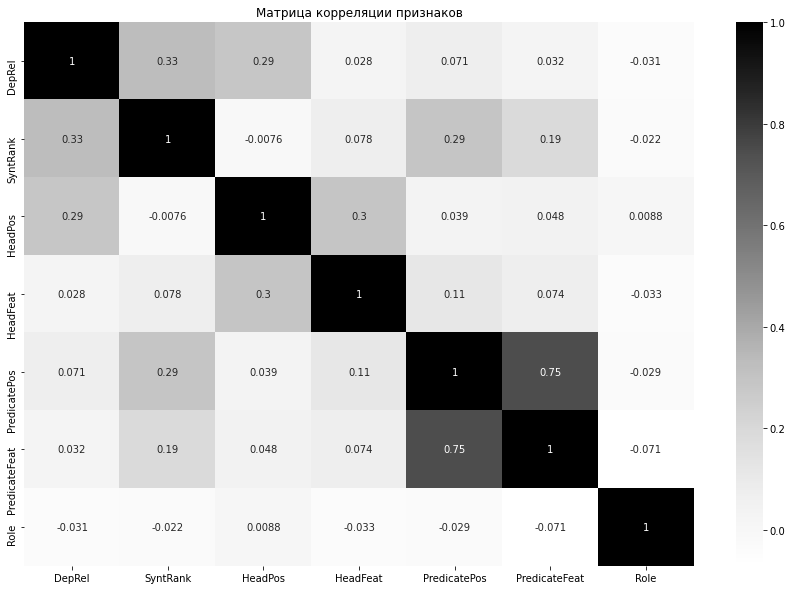

In [81]:
plt.figure(figsize=(15, 10))
df_corr = df_encode.drop(k + ['P' + text for text in k] + [i for i in range(600)], axis=1).fillna('None')
df_corr['Role'] = lb_make.fit_transform(df_corr['Role'])
sn.heatmap(df_corr.corr(), annot=True, cmap='Greys')
plt.title('Матрица корреляции признаков')
plt.show()

In [ ]:
df_final.fillna('None', inplace=True)

# удаляем признак SyntRank, так как его нет в эталонном корпусе
df_final.drop('SyntRank', axis=1, inplace=True)

# делим на обучающую и тестовую выборку
train_data = df_final[:38880].drop(['Role'], axis=1)
train_labels = df_final[:38880]['Role']

test_data = df_final[38880:].drop(['Role'], axis=1)
test_labels = df_final[38880:]['Role']

In [ ]:
# определение категориальных признаков для модели
cat_features = list(train_data.columns[:33])

In [ ]:
cb_model = CatBoostClassifier(learning_rate=0.02,
                           l2_leaf_reg=3,
                           depth=6,
                           task_type='GPU',
                           iterations=1500)
cb_model.fit(train_data, train_labels, cat_features,  verbose=True)

In [ ]:
cb_model.save_model('catboost_model')

Важность признаков:

In [ ]:
feat = cb_model.get_feature_importance(prettified=True)

In [ ]:
feat[feat['Feature Id'].str.isalpha()][:10]

,Feature Id,Importances
0,DepRel,9.065631
1,Animacy,4.256594
2,HeadFeat,3.439191
5,Case,2.306725
16,PredicateFeat,0.888729
26,fPOS,0.619800
41,HeadPos,0.449195
46,Number,0.420985
47,Gender,0.413685
56,PAspect,0.368559


Предсказание на тестовой выборке:

In [ ]:
preds = cb_model.predict(test_data)
y_pred = [pred[0] for pred in preds]

Метрики качества:

In [64]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [59]:
print('Accuracy:', accuracy_score(preds, test_labels))

Accuracy: 0.39241857981847306


In [63]:
print('Сбалансированная по классам accuracy:', balanced_accuracy_score(preds, test_labels))

Сбалансированная по классам accuracy: 0.429778952321943


In [67]:
print('F1 micro:', f1_score(preds, test_labels, average='micro'))

F1 micro: 0.39241857981847306


In [68]:
print('F1 macro:', f1_score(preds, test_labels, average='macro'))

F1 macro: 0.08525558315663843


Accuracy по классам

In [ ]:
z = pd.DataFrame(columns=['Role', 'Accuracy'])
for role in popular:
    z.loc[len(z)] = [role, len(quality[(quality['y_true'] == role) & (quality['y_pred'] == role)]) / len(quality[quality['y_true'] == role])]

In [ ]:
z.sort_values('Accuracy', ascending=False)

,Role,Accuracy
0,агенс,0.815855
1,пациенс,0.625335
2,тема,0.496241
7,содержание высказывания,0.490798
8,содержание действия,0.471049
5,говорящий,0.453978
6,причина,0.423387
4,субъект психологического состояния,0.409988
3,субъект перемещения,0.376056
9,пациенс перемещения,0.160494


Подсчет top-3 accuracy

In [51]:
probs = cb_model.predict_proba(test_data)

In [52]:
classes = cb_model.classes_

In [55]:
sum_acc = 0
for prob, label in zip(list(probs), test_labels):
    idc = np.array(prob).argsort()[-3:]
    if label in classes[idc]:
        sum_acc += 1

In [56]:
print('Значение top-3 accuracy:', sum_acc/len(test_labels))

Значение top-3 accuracy: 0.6267256502173747


Матрица ошибок для 10 наиболее частотных классов:

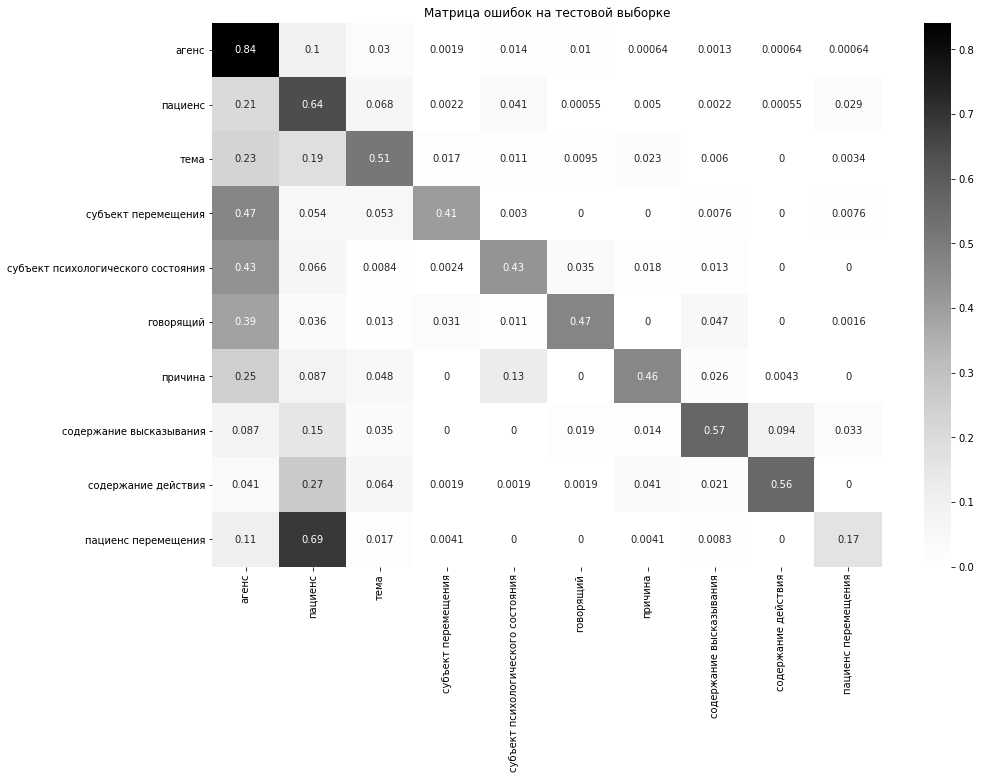

In [71]:
plt.figure(figsize=(15, 10))
sn.heatmap(confusion_matrix(test_labels, y_pred, labels=popular, normalize='true'),
           annot=True,
           xticklabels=popular, yticklabels=popular,
           cmap='Greys')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()

# На материале SynTagRus

In [82]:
k = ['Case', 'Degree', 'Number', 'Animacy', 'Gender', 'fPOS', 'Aspect', 'Tense', 'VerbForm', 'Voice', 'Person', 'Polarity', 'Mood',  'Variant']

def split_features(feats):
    d = dict.fromkeys(k, 'None')
    if feats != 'nan' and feats != '_' and feats != 'Foreign=Yes':
        for feat in feats.split('|'):
            d[feat.split('=')[0]] = feat.split('=')[1]
    return ' '.join(list(d.values()))

In [83]:
def syntagrus_to_format(filename="ru_syntagrus-ud-test.conllu"):
    data_file = open(filename, "r", encoding="utf-8")
    rows = data_file.read().strip().split('#')[1:]

    # добавляем информацию о предложении в отдельную колонку
    new_text = []
    for i in range(len(rows)):
        if i % 2 == 0:
            id = rows[i].split('=')[1].strip()
        else:
            words = rows[i].split('\n')[1:]
            for word in words:
                if len(word) > 0:
                    new_text.append(word + '\t' + id)
    
    # сохраняем в таком виде в файл
    with open('syntagrus_data.conllu', 'w', encoding='utf-8') as f:
        f.write('\n'.join(new_text))

    raw = pd.read_csv('syntagrus_data.conllu', sep='\t', 
                     names=['IdWord', 'HeadWord', 'HeadLemma', 'HeadPos', 'Xpos',
                            'HeadFeat', 'Head', 'DepRel', 'Rel', 'Space', 'IdSent'])
    
    raw['IdWord'] = raw['IdWord'].astype('int') 

    # удаляем пунктуацию
    syntag = raw.drop(raw[(raw.HeadLemma == 'PUNCT') | (raw.HeadPos == 'PUNCT')].index).reset_index(drop=True)

    # отдельно храним информацию о глаголах
    verbs = syntag[(syntag['HeadFeat'].str.contains('Fin')) & (syntag['HeadPos'] == 'VERB')][['IdWord', 'HeadLemma', 'HeadFeat', 'IdSent']]

    syntag = syntag.drop(syntag[syntag['Head'] == '_'].index)
    syntag['Head'] = syntag['Head'].astype('int')

    # соединяем две таблицы, чтобы добавить информацию о глаголе его зависимым
    syntag = syntag.merge(verbs, left_on=['Head', 'IdSent'], right_on=['IdWord', 'IdSent'], suffixes=[None, 'Pred'], how='inner')

    syntag = syntag.drop(['Xpos', 'Head', 'Rel', 'Space'], axis=1).drop(syntag[syntag.DepRel == 'parataxis'].index)
    syntag.loc[syntag.DepRel == 'obj', 'DepRel'] = 'dobj'

    # парсим грамматические признаки, чтобы рассматривать каждый из них по отдельности
    syntag['HeadFeatSplit'] = syntag['HeadFeat'].apply(lambda x: split_features(str(x)))
    syntag['HeadFeatPredSplit'] = syntag['HeadFeatPred'].apply(lambda x: split_features(str(x)))

    syntag[k] = syntag.HeadFeatSplit.str.split(expand=True)
    syntag[['P'+feat for feat in k]] = syntag.HeadFeatPredSplit.str.split(expand=True)

    # векторизуем леммы слов и предикатов
    matrix = syntag.apply(lambda x: vectorize(x['HeadLemma'], x['HeadPos']), axis=1, result_type='expand')
    matrix_2 = syntag.apply(lambda x: vectorize(x['HeadLemmaPred'], 'VERB'), axis=1, result_type='expand')
    matrices = pd.concat([matrix, matrix_2], axis=1, ignore_index=True)

    data_final = pd.concat([syntag, matrices], axis=1).drop(['HeadLemma', 'HeadLemmaPred',
                                                             'HeadFeatSplit', 'HeadFeatPredSplit', 'IdWordPred', 'HeadWord'], axis=1)
    data_final.insert(5, 'PredicatePos', ['VERB']*data_final.shape[0])

    data_final = data_final.rename({'HeadFeatPred': 'PredicateFeat'}, axis=1)

    return raw, data_final

In [96]:
raw, data_final = syntagrus_to_format()

In [97]:
preds = cb_model.predict(data_final[['DepRel', 'HeadPos', 'HeadFeat', 'PredicateFeat', 'PredicatePos'] + k + ['P'+name for name in k] + list(range(600))])

data_final.insert(0, 'Role', preds)

In [98]:
to_normal = raw.merge(data_final, on=['IdWord', 'IdSent'], how='outer')
to_normal = to_normal.drop(to_normal.columns[12:], axis=1)
to_normal['Role'] = to_normal['Role'].fillna('_')

In [99]:
to_normal.head()

,IdWord,HeadWord,HeadLemma,HeadPos_x,Xpos,HeadFeat_x,Head,DepRel_x,Rel,Space,IdSent,Role
0,1,В,в,ADP,_,_,3,case,3:case,_,2003Armeniya.xml_1,_
1,2,советский,советский,ADJ,_,Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|N...,3,amod,3:amod,_,2003Armeniya.xml_1,_
2,3,период,период,NOUN,_,Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing,11,obl,11:obl,_,2003Armeniya.xml_1,тема
3,4,времени,время,NOUN,_,Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing,3,nmod,3:nmod,_,2003Armeniya.xml_1,_
4,5,число,число,NOUN,_,Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing,11,obj,11:obj,_,2003Armeniya.xml_1,пациенс


In [100]:
g = open('syntagrus_test_result.conllu', 'a', encoding='utf-8')
for group in to_normal.groupby('IdSent'):
    g.write('# sent_id = ' + group[0] + '\n')
    group[1].drop('IdSent', axis=1).to_csv(g, mode='a', sep='\t', header=False, index=False)